# On Analyzing Real World Time Series for Forecasting Stock Data - Tencent Returns Data
- Without splitting data
- Come back to this once I finish apple 2011 to 2021 based on [DanielWicz](https://gist.github.com/DanielWicz/e2f90648e46da599080fed70d11cc09c) and [Buz](https://buse-koseoglu13.medium.com/guide-to-time-series-analysis-with-python-1-analysis-techniques-and-baseline-model-59e12fdd2eba)
    - With Daniel's, the problem is that we're passing in non-stationary data into our AR model that assumes data to be stationary. Thus, the MSE and RMSE are high. I solved this by passing in the returns, which are stationary and the MSE and RMSE are lower. 
- Once I finish this, then check of AR model and move to MA and other models. Also, update Austin on how model is performing.

In [1]:
from collections import namedtuple
from data_loader import build_stock_uts
from ts_models import Model, PersistenceWalkForward, AR, MA, ARMA, EvaluationMetric
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Stock Data Analysis

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data
11. Split Returns Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
24. Follow-up

### Load Raw Data

In [2]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2010-01-05", "2023-11-10x"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("TCEHY", "Tencent"),
    ("INTC", "Intel")
]
independent_variable = "Close"
# frequency = 
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=start_date, end_date=end_date, frequency='1d') for s in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

In [4]:
stock_symbol = 'TCEHY'
type(stocks[stock_symbol]), stocks[stock_symbol]

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Close))

In [5]:
stock_series = stocks[stock_symbol].get_series()
stock_series

array([ 4.47399998,  4.48000002,  4.29799986, ..., 39.38999939,
       39.36999893, 39.43000031])

In [6]:
stock_df = stocks[stock_symbol].get_as_df()
stock_df

,Close
Date,
2010-01-05,4.474000
2010-01-06,4.480000
2010-01-07,4.298000
2010-01-08,4.290000
2010-01-11,4.440000
...,...
2023-11-03,38.860001
2023-11-06,39.849998
2023-11-07,39.389999


### Plot Raw Data

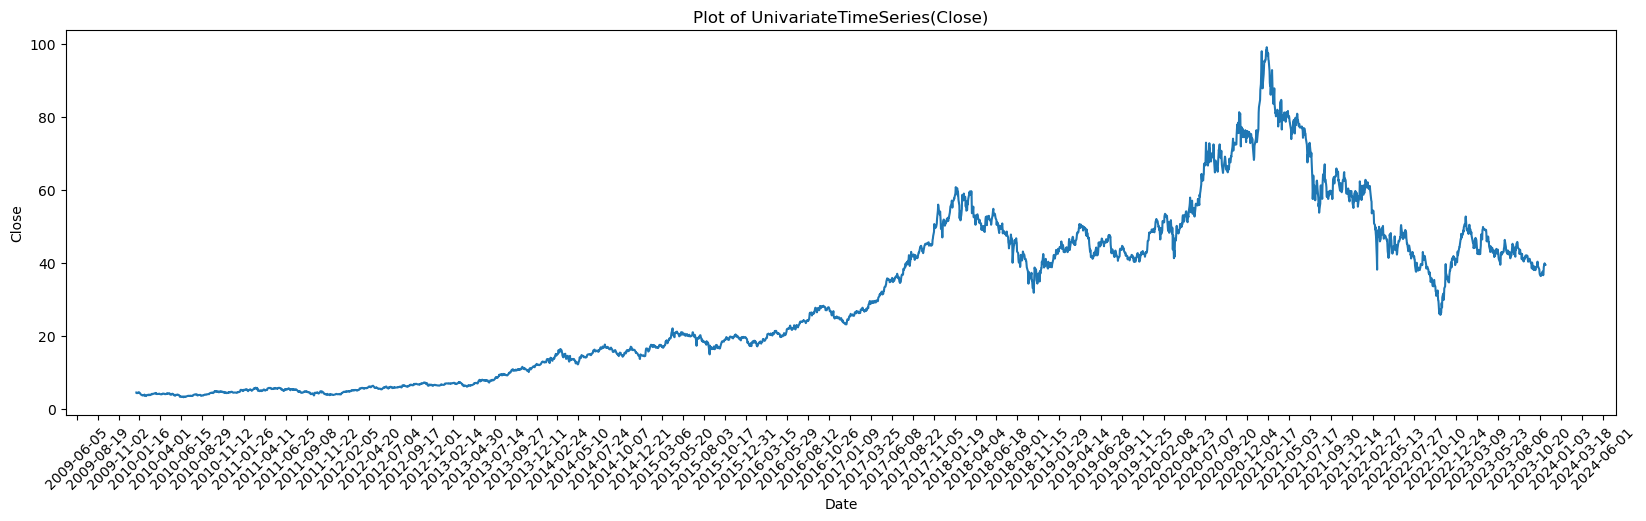

In [7]:
stocks[stock_symbol].plot(tick_skip=75)

- Tencent went public Jan 4, 2010 [yfinance](https://finance.yahoo.com/quote/TCEHY/history?period1=1262649600&period2=1698537600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true).
- What happened in 2018 for the Tencent stock close observations to fall?
    - See milestones [Tencent](https://www.tencent.com/en-us/about.html#about-con-2). Which milestones seem contradictory to this fall?
- What happened in 2020 for the Tencent stock close observations to fall?
    - Covid-19, so what happened in China during Covid? How did customers and end users react to company during the pandemic?
    - See milestones [Tencent](https://www.tencent.com/en-us/about.html#about-con-2). Which milestones seem contradictory to this fall?
- What's the future of the China market? Tencent?
- How long will it take for Tencent to see another peak stock close observation?

<AxesSubplot: xlabel='Date'>

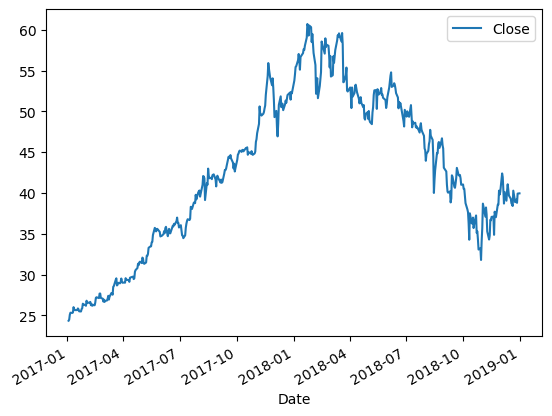

In [8]:
stock_df.loc['2017-01-01':'2019-01-01'].plot()

### Get Descriptive Statistics of Raw Data

In [9]:
stocks[stock_symbol].get_statistics()

,Close
count,3487.000000
mean,30.598971
std,22.328067
min,3.182000
25%,7.826000
50%,26.379999
75%,46.525000
max,99.010002


In [10]:
stocks[stock_symbol].max_min_range()

{'Max': Close    99.010002
 dtype: float64,
 'Min': Close    3.182
 dtype: float64,
 'Range': Close    95.828002
 dtype: float64}

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary.
    - Can we verify this non-stationary with plotting the Autocorrelation?

In [11]:
stocks[stock_symbol].stationarity_test(stock_df)

ADF Statistic: -1.274416
p-value: 0.640794 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

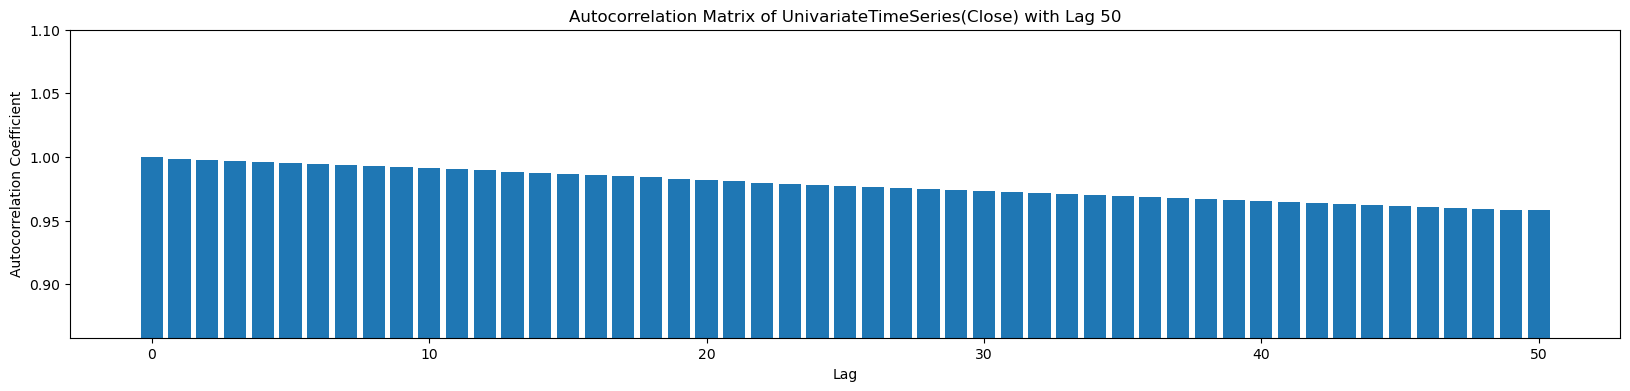

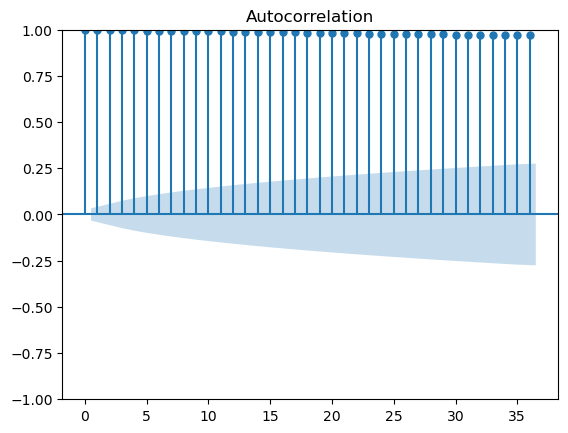

In [12]:
stocks[stock_symbol].plot_autocorrelation(50)

- Above, the data is highly correlated which means that the k-th lag observation has some impact on the most recent observation.

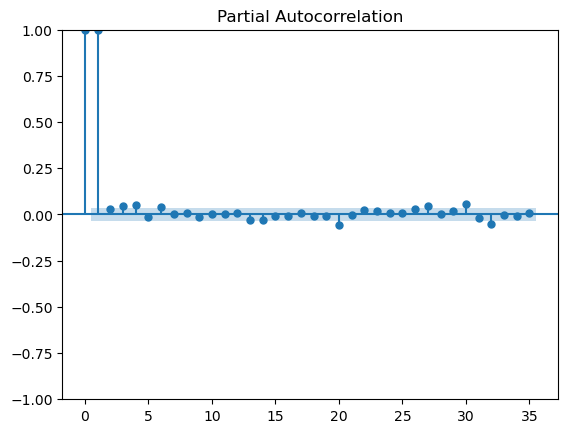

In [13]:
stocks[stock_symbol].plot_partial_autocorrelation(35)

- Above, the data shows a rapid decay at lag 2. 

### Get Returns Data

- Forecast returns
- Why: To have more stationarity (for the returns) compared to the prices `Open`/`Close` which is non-stationary
- Calculate with the `change` between $ z_t $ and $ z_{t-1} $
$$ Change = ((z_t - z_{t-1}) \div | z_{t-1} |) \space \rightarrow decimal \space form $$
$$ Percent \space Change = Change \times 100 \space \rightarrow pecent \space form $$
    - If `change` < 0, then stock price is going down, hence a **loss** from $ z_{t-1} \rightarrow z_t $
    - If `change` > 0, then stock price is going up, hence a **gain** from $ z_{t-1} \rightarrow z_t $
    - If `change` = 0, then stock price is constant, hence a **no loss nor no gain** from $ z_{t-1} \rightarrow z_t $
- NOTE: Shift the date by 1 because we don't have anything to subtract the 0th date by.

In [14]:
stock_returns = stocks[stock_symbol].data_augment_for_returns()
stock_returns

UnivariateTimeSeries(Returns)

In [15]:
stock_returns_df = stock_returns.get_as_df()
stock_returns_df

,Returns
Date,
2010-01-06,0.001341
2010-01-07,-0.040625
2010-01-08,-0.001861
2010-01-11,0.034965
2010-01-12,-0.011261
...,...
2023-11-03,0.044624
2023-11-06,0.025476
2023-11-07,-0.011543


### Plot Returns Data

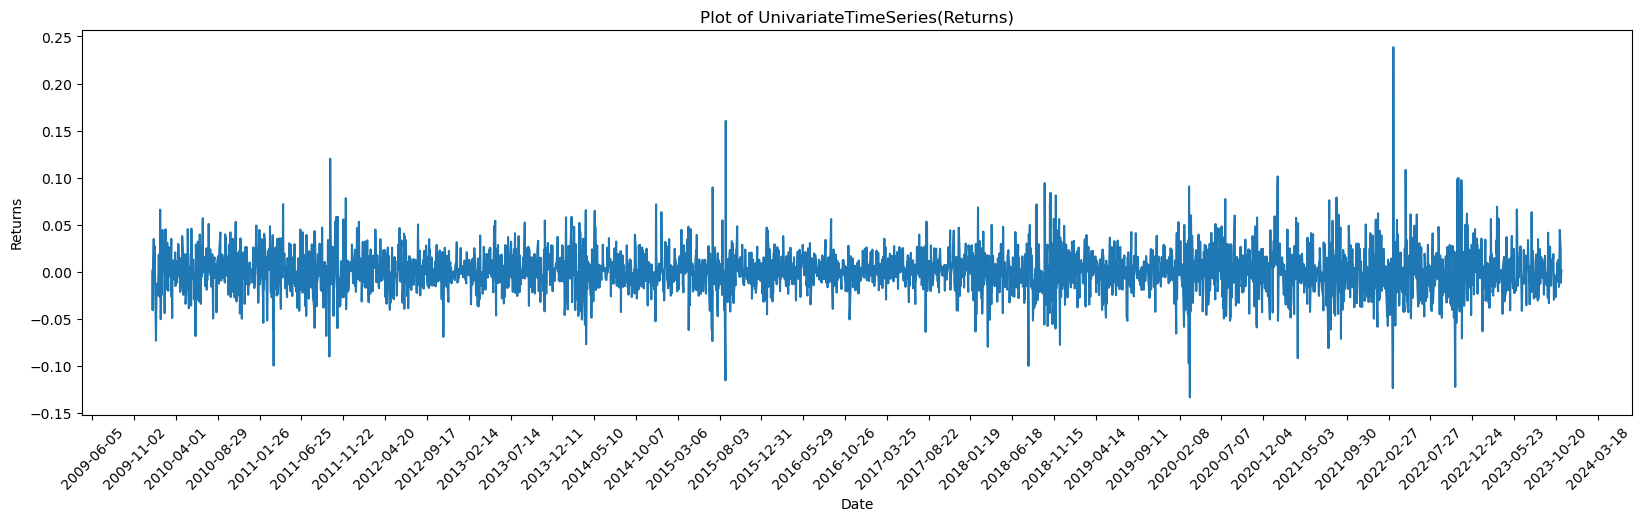

In [16]:
stock_returns.plot(tick_skip=150)

- Returns seem to have constant mean and constant variance although there are larger increases in 2015, 2019/2020, and Q1 & Q2 of 2022.

### Get Descriptive Statistics of Returns Data

In [17]:
stock_returns.get_statistics()

,Returns
count,3486.000000
mean,0.000891
std,0.023149
min,-0.133039
25%,-0.011026
50%,0.000670
75%,0.013386
max,0.238520


### Check Stationarity of Returns Data

In [18]:
stock_returns.stationarity_test(stock_returns_df)

ADF Statistic: -29.035658
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the TS is stationary
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### Plot Autocorrelation and Partial Autocorrelation of Returns Data

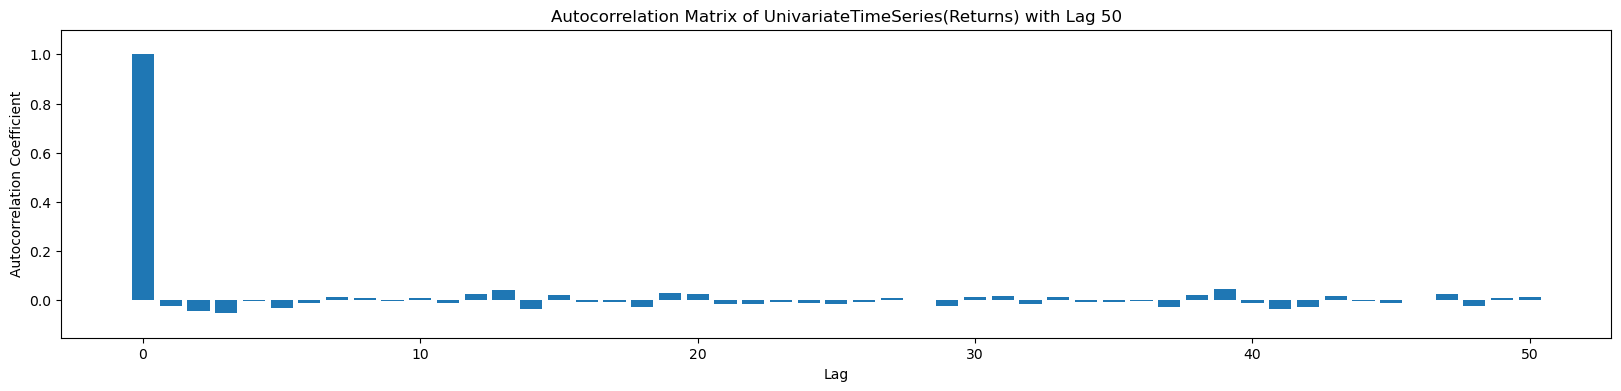

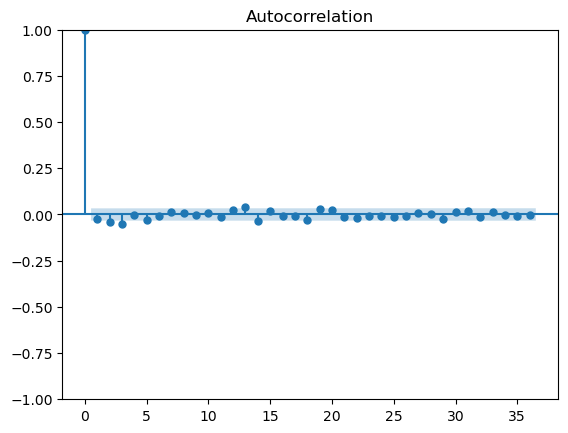

In [19]:
stock_returns.plot_autocorrelation(50)

- The ACorr rapidly decays as lag observation 1, so if we use an MA, we'd go with MA(1).

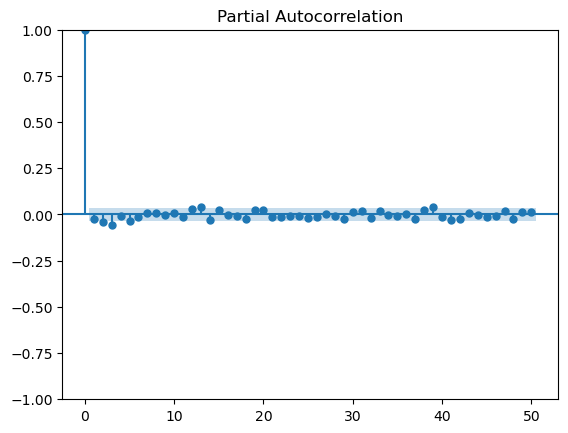

In [20]:
stock_returns.plot_partial_autocorrelation(50)

- The Partial ACorr rapidly decays as lag observation 1, so if we use an MA, we'd go with AR(1).

### Initialize Autoregressive AR(p) Model

- How to determine the proper lag value? Look at the Partial ACor plot.

In [21]:
true_labels = stocks[stock_symbol].get_series()
true_labels

array([ 4.47399998,  4.48000002,  4.29799986, ..., 39.38999939,
       39.36999893, 39.43000031])

In [22]:
end = len(stock_df)

subset_of_true_labels = true_labels[:end]
len(subset_of_true_labels), subset_of_true_labels

(3487,
 array([ 4.47399998,  4.48000002,  4.29799986, ..., 39.38999939,
        39.36999893, 39.43000031]))

In [23]:
positive_pacor = [1, 2]
negative_pacor = []
lags_to_test = positive_pacor + negative_pacor
lags_to_test = sorted(lags_to_test)
lags_to_test

[1, 2]

In [25]:
# create an object from the AR() class
ar_model_class = AR()

# call the function to train our AR model
trained_ar_models = ar_model_class.train_ar_model(subset_of_true_labels, lags_to_test)

Model 1 with a lag of 1
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 3487
Model:                     AutoReg(1)   Log Likelihood               -4714.728
Method:               Conditional MLE   S.D. of innovations              0.936
Date:                Sat, 11 Nov 2023   AIC                           9435.455
Time:                        23:55:00   BIC                           9453.925
Sample:                             1   HQIC                          9442.048
                                 3487                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0422      0.027      1.571      0.116      -0.010       0.095
y.L1           0.9989      0.001   1407.384      0.000       0.998       1.000
                            

### Predict Forecasts of Retruns Data

In [36]:
ar_predictions = ar_model_class.predict(trained_ar_models, 1, end)
ar_predictions

Model 1 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a6abaa90>
Model 2 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a6fe0cd0>


[array([ 4.51152561,  4.51751934,  4.33571077, ..., 39.39077028,
        39.37079088, 39.43072909]),
 array([        nan,  4.51703124,  4.34187181, ..., 39.4076287 ,
        39.37207663, 39.42918493])]

In [37]:
mse_gsts = EvaluationMetric.eval_mse(subset_of_true_labels, ar_predictions)
mse_gsts

expected [ 4.47399998  4.48000002  4.29799986 ... 39.38999939 39.36999893
 39.43000031] predicted [ 4.51152561  4.51751934  4.33571077 ... 39.39077028 39.37079088
 39.43072909] mse 0.0006527733768390995


ValueError: Input contains NaN.

### Plot Actual Forecasts vs Predicted Forecasts for Returns Data

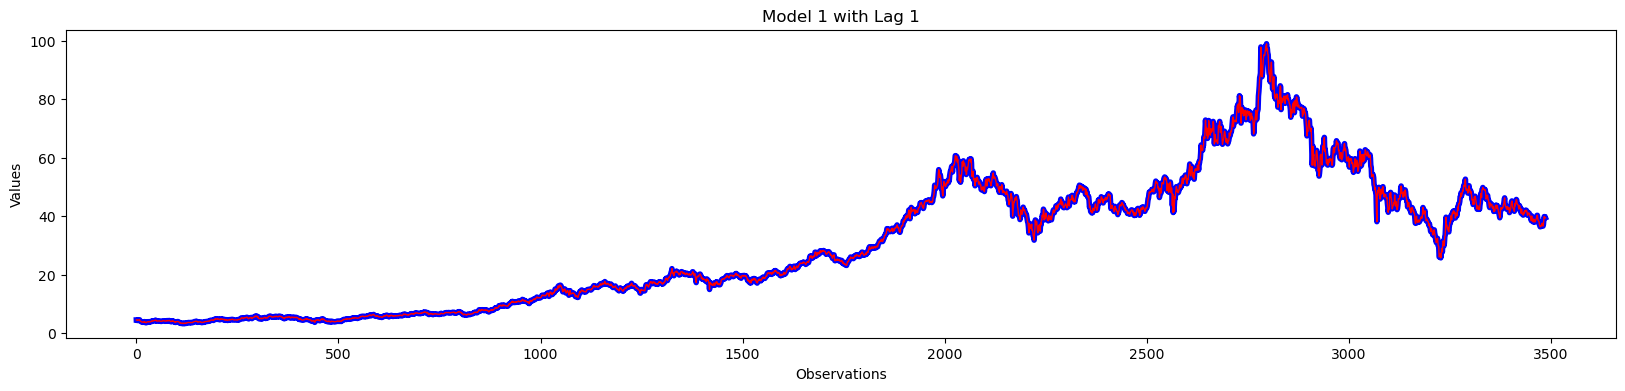

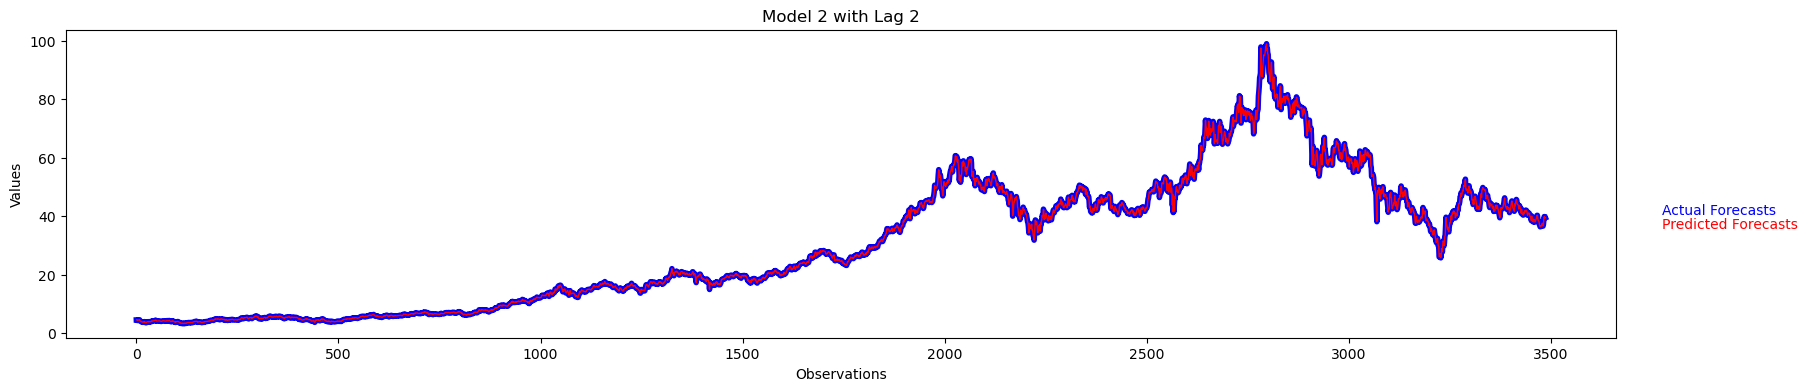

In [40]:
EvaluationMetric.plot_forecast(subset_of_true_labels, ar_predictions, lags_to_test)

### Follow-up
- What can we determine from this?
    - `AR`, `MA`, `ARMA` aren't perfoming so well on the returns data. Do I need to convert back to the raw data?
    - `Persistence RW` model on the returns mse is at 0 but the plot isn't directly aligning. There are minor errors here.
- Which AR(p) lag performs the best?
    - Difficult to state. 
- Can we do better?
    - We must lol!
- What to consider?
    - [ ] Log Likelihood
    - [ ] AIC
    - [ ] BIC
    - [ ] HQIC
    - [ ] Ljung-Box (L1) (Q)
    - [ ] Jarque-Bera (JB)
    - [ ] Prob(Q):
    - [ ] Prob(JB):
    - [ ] Heteroskedasticity (H):
    - [ ] Skew
    - [ ] Prob(H) (two-sided)
    - [ ] Kurtosis